[np.float64(0.2995902970287716), np.float64(-1309.0055519523157), np.float64(-824.0024828805181), np.float64(-4436.554596811737), np.float64(-14505.593376718505), np.float64(-349.95989628387906), np.float64(-18121.577635449), np.float64(-604.1519342054526), np.float64(-11.921210588450776), np.float64(0.2590328464284539), np.float64(-9124.092597038456), np.float64(0.4395362758950796), np.float64(-219.30354444160184), np.float64(-647.5653454260173), np.float64(-4614.968443393984), np.float64(0.2341412244568346), np.float64(-6823.8162039860035), np.float64(-421.1767427693703), np.float64(-0.8219729863194516), np.float64(-13710.389879299371), np.float64(-4892.78875316566), np.float64(-4493.183865702624), np.float64(-3327.142954519397), np.float64(-759.8830183106329), np.float64(-97.30125202753698), np.float64(0.110954383329954), np.float64(-853.9629543629271), np.float64(-3951.389183464955), np.float64(-17.04268705486902), np.float64(-845.2916077758564), np.float64(-15.388868380076019), np

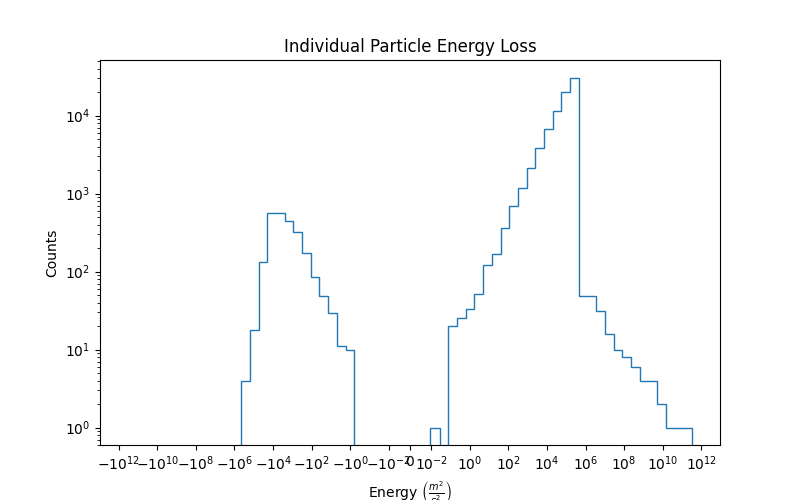

In [2]:
%matplotlib widget
import h5py
import numpy as np
import matplotlib.pyplot as plt

plt.clf()

class SplitArray:
    def __init__(self, array, m):
        self.array = array
        self.m = m
        self.n = len(array)
        self.chunk_size = self.n // m
        self.remainder = self.n % m

    def __getitem__(self, index):
        if index >= self.m or index < -self.m:
            raise IndexError("Split index out of range")

        if index < 0:
            index += self.m

        start = index * self.chunk_size + min(index, self.remainder)
        end = start + self.chunk_size
        if index < self.remainder:
            end += 1
        return self.array[start:end]

    def __len__(self):
        return self.m

def plotmean(x, y, nbins):
    xbins = SplitArray(x, nbins)

    def yinbin(bin):
        yi = np.linspace((bin)*(len(x)/len(xbins)),(bin+1)*(len(x)/len(xbins)), int(len(x)/len(xbins)+1))
        yvec = np.array([y[int(yii)] for yii in yi])
        return yvec

    ymean = [np.mean(yinbin(bindex)) for bindex in range(len(xbins)-1)]
    xmid = [(max(xbins[bindex])+min(xbins[bindex]))/2 for bindex in range(len(xbins)-1)]
    plt.scatter(xmid, ymean)

def log_histogram(data, bins):
    data = np.array(data)
    positive_data = data[data > 0]
    negative_data = -data[data < 0]

    min_val = min(positive_data.min(), negative_data.min())
    max_val = max(positive_data.max(), negative_data.max())

    log_bins = np.logspace(np.log10(min_val), np.log10(max_val), num=bins+1)

    neg_bins = -log_bins[::-1]
    all_bins = np.concatenate([neg_bins, [0], log_bins])

    counts, edges = np.histogram(data, bins=all_bins)

    plt.figure(figsize=(8, 5))
    plt.hist(data, bins=all_bins, histtype='step')

dtype = np.dtype([
    ('particle', 'i4'),
    ('time', 'f8'),
    ('energy', 'f8'),
    ('r', 'f8'),
    ('potential', 'f8'),
    ('impact_parameter', 'f8'),
    ('v', 'f8')
])

arr = []

with h5py.File("simdata.h5", "r") as f:
    for name in f:
        obj = f[name]
        if isinstance(obj, h5py.Dataset):
            v0 = obj.attrs["v0"]

            data = obj[:]

            particle_ids = np.unique(data['particle'])
            for pid in particle_ids:
                mask = data['particle'] == pid
                t = data['time'][mask]
                r = data['r'][mask]  
                e = data['energy'][mask]
                b = np.unique(data['impact_parameter'][mask])

                arr.append(e[-1])

#arr = np.concatenate(arr)
print(arr)
print(max(arr)/1e6)
log_histogram(arr, bins=30)
plt.xscale('symlog', linthresh=1e-2)
plt.yscale('log')
plt.xlabel(r'Energy $\left(\frac{m^2}{s^2}\right)$')
plt.ylabel('Counts')
plt.title('Individual Particle Energy Loss')
plt.show()



<>:36: SyntaxWarning: invalid escape sequence '\p'
<>:36: SyntaxWarning: invalid escape sequence '\p'
/var/folders/rd/thp_lwbs14n9hkhhc4r29lfw0000gn/T/ipykernel_57071/2741168745.py:36: SyntaxWarning: invalid escape sequence '\p'
  plt.ylabel(r"Relative error: $|\frac{dE/dt - \partial \phi / \partial t}{dE/dt}|$")


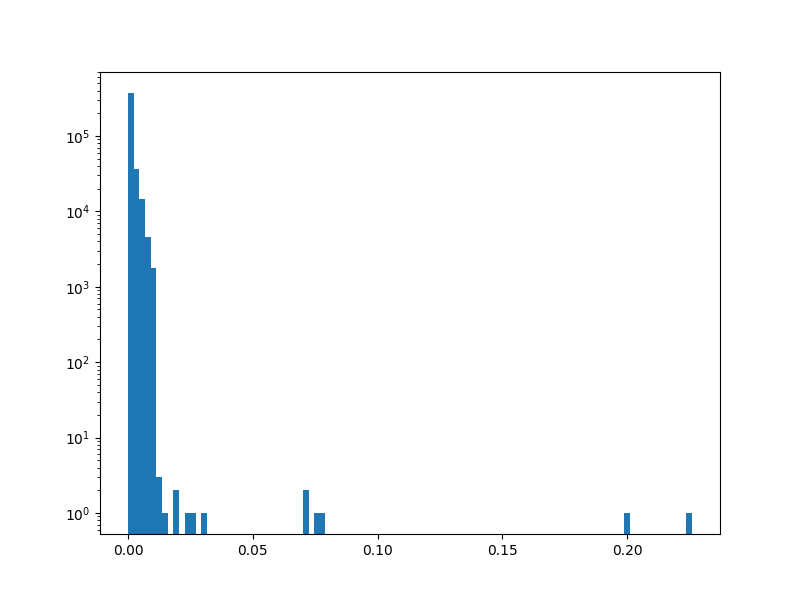

In [10]:
%matplotlib widget
import h5py
import numpy as np
import matplotlib.pyplot as plt
from matplotlib.colors import LogNorm, ListedColormap

plt.clf()

all_times = []
all_rel_errors = []

epsilon = 1e-12

with h5py.File("simdata.h5", "r") as f:
    for group_name in f.keys():
        data = f[group_name][:]
        dphi_dt = data['dphi_dt']
        dE_dt = data['dE_dt']
        t = data['time']

        denom = np.maximum(np.abs(dE_dt), epsilon)
        rel_error = np.abs(dphi_dt - dE_dt) / denom

        valid = np.isfinite(rel_error)
        all_times.append(t[valid])
        all_rel_errors.append(rel_error[valid])

all_times = np.concatenate(all_times)
all_rel_errors = np.concatenate(all_rel_errors)


'''
fig, ax = plt.subplots(figsize=(8, 6))
#plt.yscale('log')
plt.xlabel("Time (years)")
plt.ylabel(r"Relative error: $|\frac{dE/dt - \partial \phi / \partial t}{dE/dt}|$")
plt.scatter(all_times, all_rel_errors)
plt.show()
'''

plt.hist(all_rel_errors, bins=100)
plt.yscale('log')
plt.show()


In [30]:
!pwd

/Users/richardanderson/workdir/planetesimal_project/outputsShu/output04250841
